## Ethereum Stock Prices

* Import data
    * Show prices, market capital and volume
    * Analysis
* Preprocessing data
    * Complete the Index
    * Find NaN and Fix it
    * Closed Price Column
    * Normalizing
* Split data into training and test datasets
* Build the model
* Test the model
* Conclusions

### Import Libraries

In [1]:
import random
import numpy as np
import pandas as pd
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

### Import Data and Analysis

In [2]:
data = pd.read_csv('eth-eur.csv')
data.iloc[random.randint(0, data.shape[0])]

snapped_at      2017-12-10 00:00:00 UTC
price                           379.617
market_cap                  3.65422e+10
total_volume                7.65031e+08
Name: 855, dtype: object

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 896 entries, 0 to 895
Data columns (total 4 columns):
snapped_at      896 non-null object
price           896 non-null float64
market_cap      895 non-null float64
total_volume    896 non-null float64
dtypes: float64(3), object(1)
memory usage: 28.1+ KB


In [4]:
#customize index
data.snapped_at[0].split()[0]
data.snapped_at = data.snapped_at.apply(lambda x: x.split()[0])

In [5]:
data.set_index('snapped_at', inplace=True)
data.index = pd.to_datetime(data.index)

In [6]:
features = ['price', 'market_cap', 'total_volume']

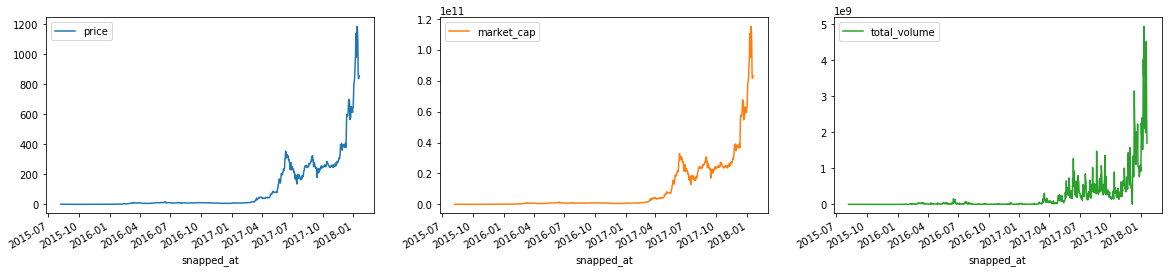

In [7]:
data[features].plot(subplots=True, layout=(1,3), figsize=(20,4));

In [8]:
data.head(24)

,price,market_cap,total_volume
snapped_at,,,
2015-08-07,2.580213,0.000000e+00,8.257608e+04
2015-08-08,1.175306,7.095505e+07,3.250759e+05
2015-08-10,0.624116,3.772033e+07,3.634980e+05
2015-08-11,0.966607,5.844581e+07,1.375588e+06
2015-08-12,1.126292,6.813006e+07,1.858814e+06
2015-08-13,1.636673,9.904778e+07,3.927292e+06
2015-08-14,1.643557,9.951063e+07,3.920484e+06
2015-08-15,1.505036,9.116528e+07,2.269451e+06
2015-08-16,1.329391,8.055977e+07,2.730304e+06


### Preprocessing Data

#### Complete the Index

The list is not complete _(2015-08-09 is missing)_ so we have to fill the blanks.

In [9]:
#check
'2015-08-09 00:00:00' in data.index

False

In [10]:
#Generate all the possible days and use them to reindex
start = data.index[data.index.argmin()]
end = data.index[data.index.argmax()]

index_complete = pd.date_range(start, end)
data = data.reindex(index_complete)

#### Find NaN and Fix it

In [11]:
#Fill the blanks with the mean between the previous and the day after

for idx in data.index:
    dayloc = data.index.get_loc(idx)
    day = data.loc[idx]
    if day.hasnans:
        #updating
        rg = slice(dayloc-1, dayloc+2)
        data.loc[idx] = data.iloc[rg].mean()
        
        print("Day <{}> updated".format(idx))

Day <2015-08-09 00:00:00> updated
Day <2017-04-02 00:00:00> updated


In [12]:
#check
data.loc['2015-08-09 00:00:00']

price           8.997108e-01
market_cap      5.433769e+07
total_volume    3.442869e+05
Name: 2015-08-09 00:00:00, dtype: float64

In [13]:
#Checking if we have NaN in another place
data[data.isnull().any(axis=1)].count()

price           0
market_cap      0
total_volume    0
dtype: int64

#### Closed Price Column

In [14]:
new_column = 'closed_price'
datab = data.copy()

nc = list()

for idx in data.index:
    dayloc = data.index.get_loc(idx)
    
    #we put the price in the day after as closed price
    if dayloc == len(data.index)-1:
        #last position will not have closed_price
        closed_price = np.nan
    else:
        closed_price = data.iloc[dayloc+1].price
    
    nc.append(closed_price)

data[new_column] = nc
data.tail(5)

,price,market_cap,total_volume,closed_price
2018-01-15,1084.204749,1.051702e+11,1.988101e+09,871.038635
2018-01-16,871.038635,8.450991e+10,4.236883e+09,838.829188
2018-01-17,838.829188,8.140486e+10,4.516756e+09,846.823344
2018-01-18,846.823344,8.219815e+10,2.632209e+09,856.639434
2018-01-19,856.639434,8.316864e+10,1.691466e+09,NaN


#### Normalizing

In [15]:
#Scale the data
scaler = StandardScaler()

data[features] = scaler.fit_transform(data[features])
data.describe()

,price,market_cap,total_volume,closed_price
count,8.970000e+02,8.970000e+02,8.970000e+02,896.000000
mean,-3.168529e-17,6.337059e-17,-6.337059e-17,101.637873
std,1.000558e+00,1.000558e+00,1.000558e+00,184.025144
min,-5.501562e-01,-5.415878e-01,-4.110179e-01,0.381455
25%,-5.135045e-01,-5.077948e-01,-4.031238e-01,7.150372
50%,-4.943143e-01,-4.909240e-01,-3.822954e-01,10.664045
75%,3.991864e-01,3.770718e-01,-1.335186e-02,175.193903
max,5.904563e+00,5.955011e+00,9.357096e+00,1187.079009


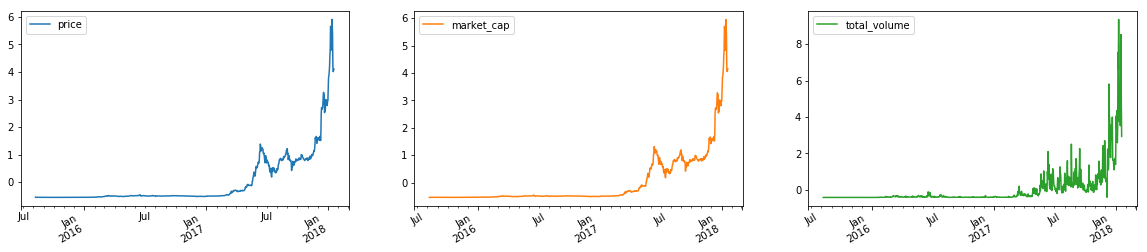

In [16]:
data[features].plot(subplots=True, layout=(1,3), figsize=(20,4));

### Split Data into Training and Test Datasets

In [17]:
X_train, X_test, y_train, y_test = train_test_split(data[features], data.closed_price, test_size=0.20, random_state=42)

In [18]:
print("Size X_train: {}".format(X_train.shape[0]))
print("Size X_test: {}".format(X_test.shape[0]))

Size X_train: 717
Size X_test: 180


## Check Tensorflow and GPU

In [19]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer'
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/Users/samuel/anaconda/envs/py3/lib/python3.5/site-packages/ipykernel_launcher.py:11: UserWarning: No GPU found. Please use a GPU to train your neural network.
  # This is added back by InteractiveShellApp.init_path()


In [90]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from sklearn.preprocessing import MinMaxScaler

#print(X_train.head()) 
#print(y_train.head())
X_train1 = np.expand_dims(X_train, 2)
y_train1 = np.expand_dims(y_train, 1)

print(X_train1.shape)
print(X_train.iloc[0].tolist())
print(X_train1[0])

model = Sequential()
model.add(LSTM(8, input_shape=(3,1) ))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train1, y_train1, epochs=10, batch_size=32, verbose=1)


(717, 3, 1)
[2.5957831976648644, 2.6123039556782013, 1.6326573256810335]
[[ 2.5957832 ]
 [ 2.61230396]
 [ 1.63265733]]
Epoch 1/10
717/717 [==============================] - 3s 5ms/step - loss: nan  98
Epoch 2/10
717/717 [==============================] - 0s 654us/step - loss: nan
Epoch 3/10
717/717 [==============================] - 1s 713us/step - loss: nan
Epoch 4/10
717/717 [==============================] - 0s 578us/step - loss: nan
Epoch 5/10
717/717 [==============================] - 0s 619us/step - loss: nan
Epoch 6/10
717/717 [==============================] - 0s 622us/step - loss: nan
Epoch 7/10
717/717 [==============================] - 0s 529us/step - loss: nan
Epoch 8/10
717/717 [==============================] - 0s 537us/step - loss: nan
Epoch 9/10
717/717 [==============================] - 0s 523us/step - loss: nan
Epoch 10/10
717/717 [==============================] - 0s 521us/step - loss: nan
